## One Year Preprocess Region t

Generate all the `preprocess_region_t` files for a particular region for a particular year. And move all those files to s3.

In [1]:
import s3fs

from fireatlas import preprocess, postprocess, FireConsts, FireIO, FireTime, FireMain

tst = [2023, 1, 1, 'AM']
ted = [2024, 1, 1, 'AM']
region = ('WesternUS',[-125.698046875,31.676476158707615,
                       -101.00078125,49.51429477264348])
list_of_ts = FireTime.t_generator(tst, ted)

In [9]:
%%time
output_filename = preprocess.preprocess_region(region)
FireIO.copy_from_local_to_s3(output_filename)

2024-03-26 14:22:47,583 - FireLog - INFO - Preprocessing has already occurred for this region.
2024-03-26 14:22:47,584 - FireLog - INFO - func:preprocess_region took: 6.29 ms
2024-03-26 14:22:47,590 - FireLog - INFO - running replace on filepath=data/FEDSpreprocessed/WesternUS/WesternUS.json
2024-03-26 14:22:47,590 - FireLog - INFO - uploading file data/FEDSpreprocessed/WesternUS/WesternUS.json to maap-ops-workspace/shared/gsfc_landslides/FEDSpreprocessed/WesternUS/WesternUS.json


CPU times: user 105 ms, sys: 15.9 ms, total: 121 ms
Wall time: 453 ms


In [10]:
s3fs.S3FileSystem().glob(f"{FireConsts.dirprpdata}WesternUS/*")

['maap-ops-workspace/shared/gsfc_landslides/FEDSpreprocessed/WesternUS/WesternUS.json']

In [ ]:
%%time
for t in list_of_ts:
    local_filename = preprocess.preprocess_region_t(t, sensor="VIIRS", region=region)
    FireIO.copy_from_local_to_s3(local_filename)

2024-03-26 14:27:21,575 - FireLog - INFO - func:read_region took: 434.71 ms
2024-03-26 14:27:21,576 - FireLog - INFO - filtering and clustering 2023-1-24 AM, VIIRS, WesternUS
2024-03-26 14:27:21,702 - FireLog - INFO - func:read_preprocessed_input took: 125.42 ms
2024-03-26 14:27:21,850 - FireLog - INFO - func:read_preprocessed_input took: 148.04 ms
2024-03-26 14:27:24,381 - FireLog - INFO - func:do_clustering took: 2.73 ms
2024-03-26 14:27:24,393 - FireLog - INFO - func:preprocess_region_t took: 3.26 sec
2024-03-26 14:27:24,398 - FireLog - INFO - running replace on filepath=data/FEDSpreprocessed/WesternUS/VIIRS/20230124_AM.txt
2024-03-26 14:27:24,399 - FireLog - INFO - uploading file data/FEDSpreprocessed/WesternUS/VIIRS/20230124_AM.txt to maap-ops-workspace/shared/gsfc_landslides/FEDSpreprocessed/WesternUS/VIIRS/20230124_AM.txt
2024-03-26 14:27:24,813 - FireLog - INFO - func:read_region took: 272.95 ms
2024-03-26 14:27:24,814 - FireLog - INFO - filtering and clustering 2023-1-24 PM, V

Once that process completes we can take a look at how long it took to generate each file. Keep in mind that all this happened purely in serial.

<Axes: xlabel='datetime', ylabel='seconds'>

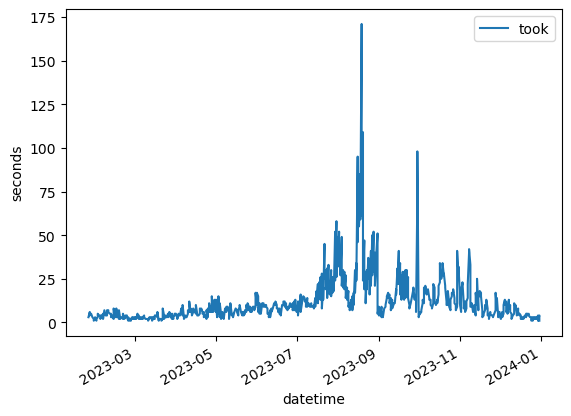

In [73]:
import pandas as pd

s3_files = s3fs.S3FileSystem().glob(f"{FireConsts.dirprpdata}WesternUS/VIIRS/2023*", detail=True)
s3_files_df = pd.json_normalize(s3_files.values())

# note that the first 24 days of the year were processed separately
s3_files_df["took"] = s3_files_df.iloc[24*2:]["LastModified"].diff().dt.seconds
s3_files_df["datetime"] = pd.to_datetime(s3_files_df.name.apply(lambda path: path.split('/')[-1].split('_')[0]))

s3_files_df.plot(x="datetime", y="took", ylabel="seconds")